# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [3]:
df['Sentiment'] = np.where((df['Sentiment'] == 'Positive') | (df['Sentiment'] == 'Extremely Positive'), 1, 0)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


Сбалансированы ли классы?

In [4]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Да, сбалансированы. Негативные - 44%, положительные 56%.

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
df = df.fillna('Unknown')
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [8]:
tweets = train['OriginalTweet']
tweets = ' '.join(tweets)
tweets = tweets.lower()
tweets = pd.Series(tweets.split())

tokens = dict(tweets.value_counts())

Какой размер словаря получился?

In [9]:
len(tokens)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [10]:
list(tokens)[:10]

['the', 'to', 'and', 'of', 'a', 'in', 'for', '#coronavirus', 'is', 'are']

**Ответ:** Ну 9 из 10 слов являются служебными словами и не несут лексической ценности, а 10 слово - коронавирус, тема постов.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [11]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
for stopword in stopwords.words('english'):
    if stopword in tokens.keys():
        del tokens[stopword]

list(tokens.items())[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:**  3 из 10 слов - ковид, не особо информативно. Слово 'people' - тоже. &amp - амперсанд, вообще не слово. Оставшиеся 5 относятся к теме продовольствия, покупки продовольствия и т. д. Таким образом, эта тема чаще всего всплывала в твитах.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [12]:
list(tokens.items())[-20:]

[('pmt', 1),
 ('acres', 1),
 ('cucumber', 1),
 ('https://t.co/x69jqbisox', 1),
 ('had!', 1),
 ('#springcleaning', 1),
 ('https://t.co/l8jnzxjgwo', 1),
 ('contained,', 1),
 ('readiness,', 1),
 ('kick-in', 1),
 ('(covid-19,', 1),
 ('impacts)', 1),
 ('https://t.co/wa7kcdwqea', 1),
 ('@linkedin', 1),
 ('clare', 1),
 ('connors', 1),
 ('levins', 1),
 ('587-4272', 1),
 ('https://t.co/6ytxpz5ug9', 1),
 ('https://t.co/7j2y3rsld9', 1)]

**Ответ:** Ну, тут просто абсолютно нерелевантные вещи находятся. Опечатки, ссылки, странные слова типа bonesaw (интересно, маньяк или фанат гостмейна писал), числа ну и просто слова, которые встречаются редко и не дают толком никакой информации.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [13]:
from nltk.tokenize import TweetTokenizer

tweets = train['OriginalTweet']
tweets = ' '.join(tweets)
tokenizer = TweetTokenizer()

tokens = dict(pd.Series(tokenizer.tokenize(tweets)).value_counts())
list(tokens)[:10]

['the', '.', 'to', ',', 'and', 'of', 'a', 'in', '?', 'for']

**Ответ:** Добавилась пунктуация, теперь топ слов состоит только из служебных слов и пунктуации. Раньше пунктуация была прилеплена к слову, но TweetTokenizer умный, поэтому считает их отдельно без ущерба подсчету нормальных слов.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [14]:
from string import punctuation

for stopword in stopwords.words('english'):
    if stopword in tokens.keys():
        del tokens[stopword]

for c in punctuation:
    if c in tokens.keys():
        del tokens[c]

list(tokens)[:10]

['Â',
 '\x82',
 '19',
 '#coronavirus',
 'I',
 '\x92',
 'prices',
 'COVID',
 'food',
 'store']

**Ответ:** Да, есть: '\x92', '\x82'.

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [15]:
res = {}
for key in tokens.keys():
    if len(key) == 1:
        if ord(key) >= 128:
            continue
    res[key] = tokens[key]

print(list(res)[:10])
print(list(res)[-20:])

['19', '#coronavirus', 'I', 'prices', 'COVID', 'food', 'store', 'supermarket', 'grocery', 'people']
['https://t.co/2ehsEAUFKV', 'reluctantly', 'telecos', '#Reduceinternetpricesnow', 'https://t.co/flj84Jb1Un', 'careÃ', 'alrighty', '@lanxshoes', 'Hamper', 'https://t.co/apr3lm4hCt', '#Superheroes', 'Skyrocket', 'https://t.co/pWIPC0Qy9I', 'supermarket-raiders', 'panic-using', 'over-stocking', 'shitkickers', '#supermarketraiders', 'underprepared', 'https://t.co/7j2Y3rSld9']


**Ответ:** Появилось слово I, которое вообще-то стоп-слово. Появилось оно из-за того, что в стоп словах оно в нижнем регистре, а по правилам языка всегда пишется с большой буквы.

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [16]:
list({key: val for key, val in res.items() if key.startswith('#')}.items())[:10]

[('#coronavirus', 7143),
 ('#COVID19', 1844),
 ('#Covid_19', 1463),
 ('#Coronavirus', 1281),
 ('#COVID2019', 927),
 ('#toiletpaper', 657),
 ('#covid19', 568),
 ('#COVID', 542),
 ('#CoronaCrisis', 426),
 ('#CoronaVirus', 351)]

**Ответ:** Ну тут всё про ковид, кроме одного хэштега про туалетную бумагу(?). Хэштегов много

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [17]:
list({key: val for key, val in res.items() if key.startswith('https://t.co')}.items())[:10]

[('https://t.co/oXA7SWtoNd', 5),
 ('https://t.co/gP3EusapL8', 4),
 ('https://t.co/3GBBDpdjat', 3),
 ('https://t.co/e2ZNXajPre', 3),
 ('https://t.co/WuiEEfSNOj', 3),
 ('https://t.co/CATKegAyOY', 3),
 ('https://t.co/WrLHYzIzAA', 3),
 ('https://t.co/kuwIpF1KQW', 3),
 ('https://t.co/DefTruI1PfÃ\x82Â', 3),
 ('https://t.co/bYlqXrjmNT', 3)]

**Ответ:** Абсолютно несравнима(сотни против единиц). Информация о ссылке бесполезна.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [18]:
def custom_tokenizer(text):
    text = text.lower()
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    tokens = [token for token in tokens if token not in set(stopwords.words('english')) and
           token not in set(punctuation) and
           not(len(token) == 1 and ord(token) >= 128) and not(token.startswith('https://t.co'))]

    return tokens


In [60]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv = cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Почти в 2 раза меньше словаря из задания 2.

Посмотрим на какой-нибудь конкретный твитт:

In [58]:
ind = 9023
tweet = train.iloc[ind]['OriginalTweet']
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']


('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [59]:
one = cv.transform([tweet])

df_one = pd.DataFrame(one.toarray(), columns=cv.get_feature_names_out())

one = np.squeeze(one.toarray())
index = np.squeeze(np.argwhere(one != 0))

df_one.iloc[0, index]

#coronavirusoutbreak    1
#covid2019              1
@skynews                1
brainless               1
ffs                     1
food                    1
france                  1
lets                    1
nice                    1
one                     1
panic                   1
ppl                     1
queueing                1
show                    1
Name: 0, dtype: int64

**Ответ:** Все слова по одному разу встречаются, поэтому невозможно определить, какой токен важнее.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tv = tv.fit(train['OriginalTweet'])


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
one = tv.transform([tweet])

df_one = pd.DataFrame(one.toarray(), columns=tv.get_feature_names_out())

one = np.squeeze(one.toarray())
index = np.squeeze(np.argwhere(one != 0))

df_one.iloc[0, index]

#coronavirusoutbreak    0.225843
#covid2019              0.168252
@skynews                0.310426
brainless               0.386764
ffs                     0.324474
food                    0.113289
france                  0.320473
lets                    0.301211
nice                    0.254273
one                     0.163067
panic                   0.147595
ppl                     0.255006
queueing                0.354346
show                    0.244065
Name: 0, dtype: float64

**Ответ:** Тут определились лучше, потому что учитывается, как часто слова встречаются в других твитах.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [25]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [26]:
tweet = train.loc[17122]['OriginalTweet']
one = tv.transform([tweet])

df_one = pd.DataFrame(one.toarray(), columns=tv.get_feature_names_out())

one = np.squeeze(one.toarray())
index = np.squeeze(np.argwhere(one != 0))

df_one.iloc[0, index]

amazing          0.249863
amid             0.185275
calls            0.252928
charity          0.281627
community        0.212347
coronavirus      0.157057
demand           0.146113
donations        0.255822
emergency        0.209756
food             0.110680
foodbank         0.326233
hackney          0.404928
low              0.193395
packages         0.281627
response         0.209101
run              0.225067
unprecedented    0.256254
Name: 0, dtype: float64

**Ответ:** Само слово amazing имеет довольно большой вес. Также такие слова, как charity, donations, unprecedented. Обычно связаны с чем-то хорошим и имеют тут большой вес, поэтому будет полезно для определения тональности.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [27]:
X_train = train['OriginalTweet']
X_test = test['OriginalTweet']
y_train = train['Sentiment']
y_test = test['Sentiment']

X_train_cv = cv.transform(X_train)
X_train_tv = tv.transform(X_train)
X_test_cv = cv.transform(X_test)
X_test_tv = tv.transform(X_test)

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_cv = LogisticRegression(max_iter=200, random_state=42)
lr_tv = LogisticRegression(max_iter=200, random_state=42)
lr_cv.fit(X_train_cv, y_train)
lr_tv.fit(X_train_tv, y_train)

y_train_pred_cv = lr_cv.predict(X_train_cv)
y_train_pred_tv = lr_tv.predict(X_train_tv)
y_test_pred_cv = lr_cv.predict(X_test_cv)
y_test_pred_tv = lr_tv.predict(X_test_tv)

print('TRAIN CV', accuracy_score(y_train, y_train_pred_cv))
print('TRAIN TV', accuracy_score(y_train, y_train_pred_tv))
print('TEST CV', accuracy_score(y_test, y_test_pred_cv))
print('TEST TV', accuracy_score(y_test, y_test_pred_tv))

TRAIN CV 0.9844510892780863
TRAIN TV 0.9254592054677488
TEST CV 0.8672513454255532
TEST TV 0.8533984452860275


**Ответ:** TV хуже себя показывает на тренировочной выборке, но на тестовой примерно одинаково(хоть и tv всё равно чуть хуже). Качество моделей весьма неплохое.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [29]:
from nltk.stem.snowball import SnowballStemmer

In [30]:
def custom_stem_tokenizer(text):
    text = text.lower()
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    tokens = [token for token in tokens if token not in set(stopwords.words('english')) and
           token not in set(punctuation) and
           not(len(token) == 1 and ord(token) >= 128) and not(token.startswith('https://t.co'))]

    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [31]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [32]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv_stem.fit(X_train)

tv_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tv_stem.fit(X_train)

print('stem vocab', len(cv_stem.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


stem vocab 36652


**Ответ**  уменьшился на 9000~

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [33]:
X_train_cv_stem = cv_stem.transform(X_train)
X_train_tv_stem = tv_stem.transform(X_train)
X_test_cv_stem = cv_stem.transform(X_test)
X_test_tv_stem = tv_stem.transform(X_test)

lr_cv_stem = LogisticRegression(max_iter=500, random_state=42)
lr_tv_stem = LogisticRegression(max_iter=500, random_state=42)
lr_cv_stem.fit(X_train_cv_stem, y_train)
lr_tv_stem.fit(X_train_tv_stem, y_train)

LogisticRegression(max_iter=500, random_state=42)

In [34]:
y_train_pred_cv_stem = lr_cv_stem.predict(X_train_cv_stem)
y_train_pred_tv_stem = lr_tv_stem.predict(X_train_tv_stem)
y_test_pred_cv_stem = lr_cv_stem.predict(X_test_cv_stem)
y_test_pred_tv_stem = lr_tv_stem.predict(X_test_tv_stem)

print('TRAIN CV STEM', accuracy_score(y_train, y_train_pred_cv_stem))
print('TRAIN TV STEM', accuracy_score(y_train, y_train_pred_tv_stem))
print('TEST CV STEM', accuracy_score(y_test, y_test_pred_cv_stem))
print('TEST TV STEM', accuracy_score(y_test, y_test_pred_tv_stem))
print('')
print('TRAIN CV', accuracy_score(y_train, y_train_pred_cv))
print('TRAIN TV', accuracy_score(y_train, y_train_pred_tv))
print('TEST CV', accuracy_score(y_test, y_test_pred_cv))
print('TEST TV', accuracy_score(y_test, y_test_pred_tv))

TRAIN CV STEM 0.9718923536950022
TRAIN TV STEM 0.9158906450234943
TEST CV STEM 0.8672513454255532
TEST TV STEM 0.8560892963922663

TRAIN CV 0.9844510892780863
TRAIN TV 0.9254592054677488
TEST CV 0.8672513454255532
TEST TV 0.8533984452860275


**Ответ:** На трейне accuracy стало меньше, а на тесте немного повысилось на tv. Есть смысл использовать стемминг.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [35]:
tokens = custom_stem_tokenizer(' '.join(X_train))
tokens = pd.Series(tokens)
tokens.value_counts()[0]

8809

In [36]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=8000).fit(X_train)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


**Ответ:** Слово #coronavirus встречается в текстах очень часто, поэтому большое число.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [37]:
tokens.value_counts().index[3699],  tokens.value_counts()[3699]

('cbd', 11)

In [38]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(X_train)
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


3700


In [39]:
X_train_cv_df = cv_df.transform(X_train)
X_test_cv_df = cv_df.transform(X_test)

lr_cv_df = LogisticRegression(max_iter=200, random_state=42)
lr_cv_df.fit(X_train_cv_df, y_train)

LogisticRegression(max_iter=200, random_state=42)

In [40]:
y_train_pred_cv_df = lr_cv_df.predict(X_train_cv_df)
y_test_pred_cv_df = lr_cv_df.predict(X_test_cv_df)

print('TRAIN CV STEM', accuracy_score(y_train, y_train_pred_cv_stem))
print('TEST CV STEM', accuracy_score(y_test, y_test_pred_cv_stem))
print('')
print('TRAIN CV DF', accuracy_score(y_train, y_train_pred_cv_df))
print('TEST CV DF', accuracy_score(y_test, y_test_pred_cv_df))

TRAIN CV STEM 0.9718923536950022
TEST CV STEM 0.8672513454255532

TRAIN CV DF 0.9286629645450662
TEST CV DF 0.8680486346422165


**Ответ:** Точность на тесте немного повысилась.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_train_cv_df = scaler.fit_transform(X_train_cv_df)
X_test_cv_df = scaler.transform(X_test_cv_df)

lr_cv_df = LogisticRegression(max_iter=500, random_state=42)
lr_cv_df.fit(X_train_cv_df, y_train)

y_train_pred_cv_df_scaled = lr_cv_df.predict(X_train_cv_df)
y_test_pred_cv_df_scaled = lr_cv_df.predict(X_test_cv_df)


print('TRAIN CV DF', accuracy_score(y_train, y_train_pred_cv_df))
print('TEST CV DF', accuracy_score(y_test, y_test_pred_cv_df))
print('')
print('TRAIN CV DF SCALED', accuracy_score(y_train, y_train_pred_cv_df_scaled))
print('TEST CV DF SCALED', accuracy_score(y_test, y_test_pred_cv_df_scaled))

coefs = np.squeeze(lr_cv_df.coef_)
words = cv_df.get_feature_names_out()

s = pd.Series(data=coefs, index=words)

positive = s.sort_values(ascending=False)[:10]
negative = s.sort_values(ascending=True)[:10]

res = pd.concat([negative, positive])



TRAIN CV DF 0.9286629645450662
TEST CV DF 0.8680486346422165

TRAIN CV DF SCALED 0.9416915847928236
TEST CV DF SCALED 0.8446282639027307


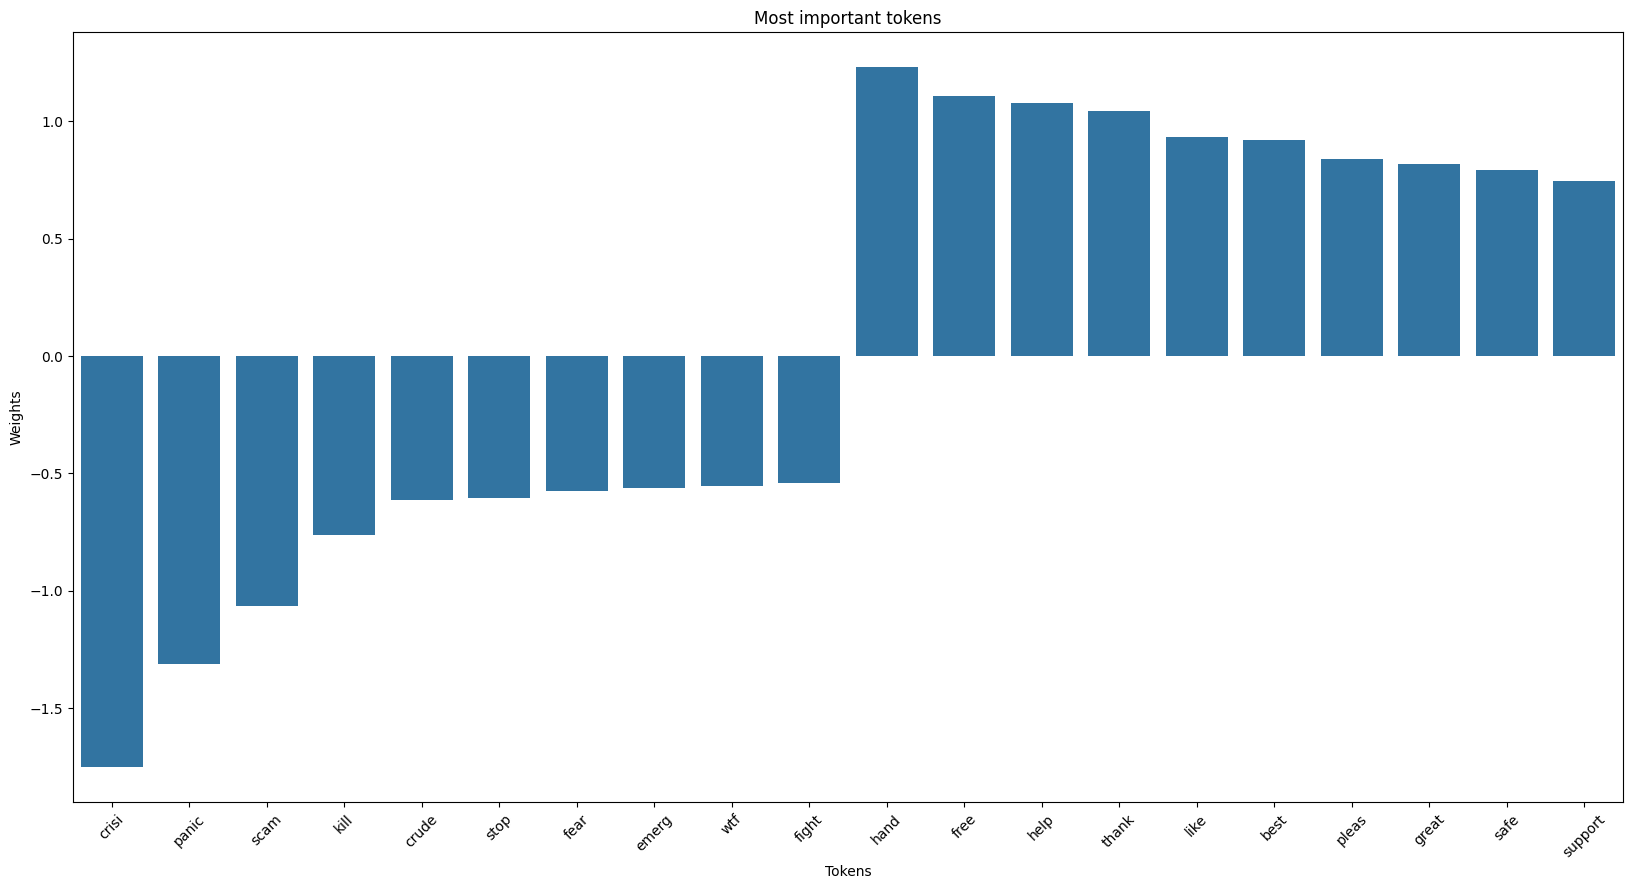

In [53]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=res.index, y=res.values)
ax.set_title('Most important tokens')
ax.set_ylabel('Weights')
ax.set_xlabel('Tokens')
plt.xticks(rotation=45)
plt.show()

**Ответ:** Токены с большими весами имеют явное положительное или отрицательное значение.

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

**Ответ:** Они абсолютно бесполезны. Условный kolya_magnitola2004 может писать всё, что угодно. Кодировать нет смысла.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

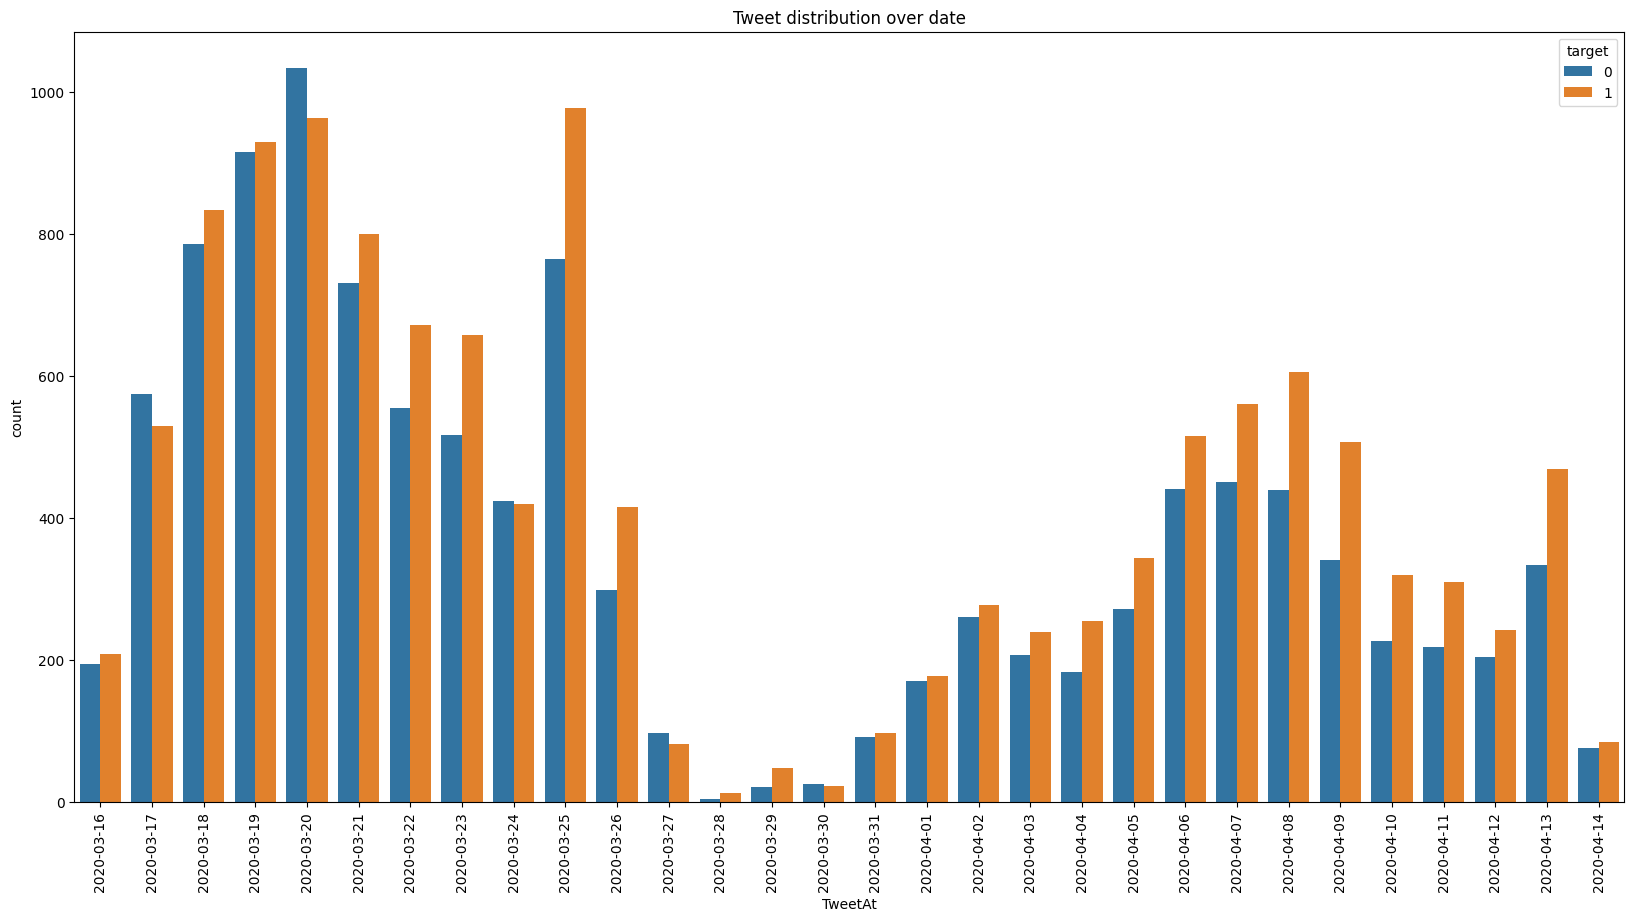

In [42]:
TweetAt = pd.to_datetime(train['TweetAt'], format="%d-%m-%Y")
TweetAt = pd.DataFrame({'TweetAt': TweetAt, 'target': y_train})
time_df = TweetAt.groupby(['target']).value_counts().reset_index().sort_values(by=['TweetAt'])

fig, ax = plt.subplots(figsize=(20,10))
ax.set_title('Tweet distribution over date')
ax = sns.barplot(data=time_df, x='TweetAt', y='count', hue='target')
plt.xticks(rotation=90)
plt.show()


**Ответ:** Бесполезно, в каждый день примерно одинаковое количество позитивных и негативных твитов.



Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [43]:
location = train['Location']
len(location.unique())

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

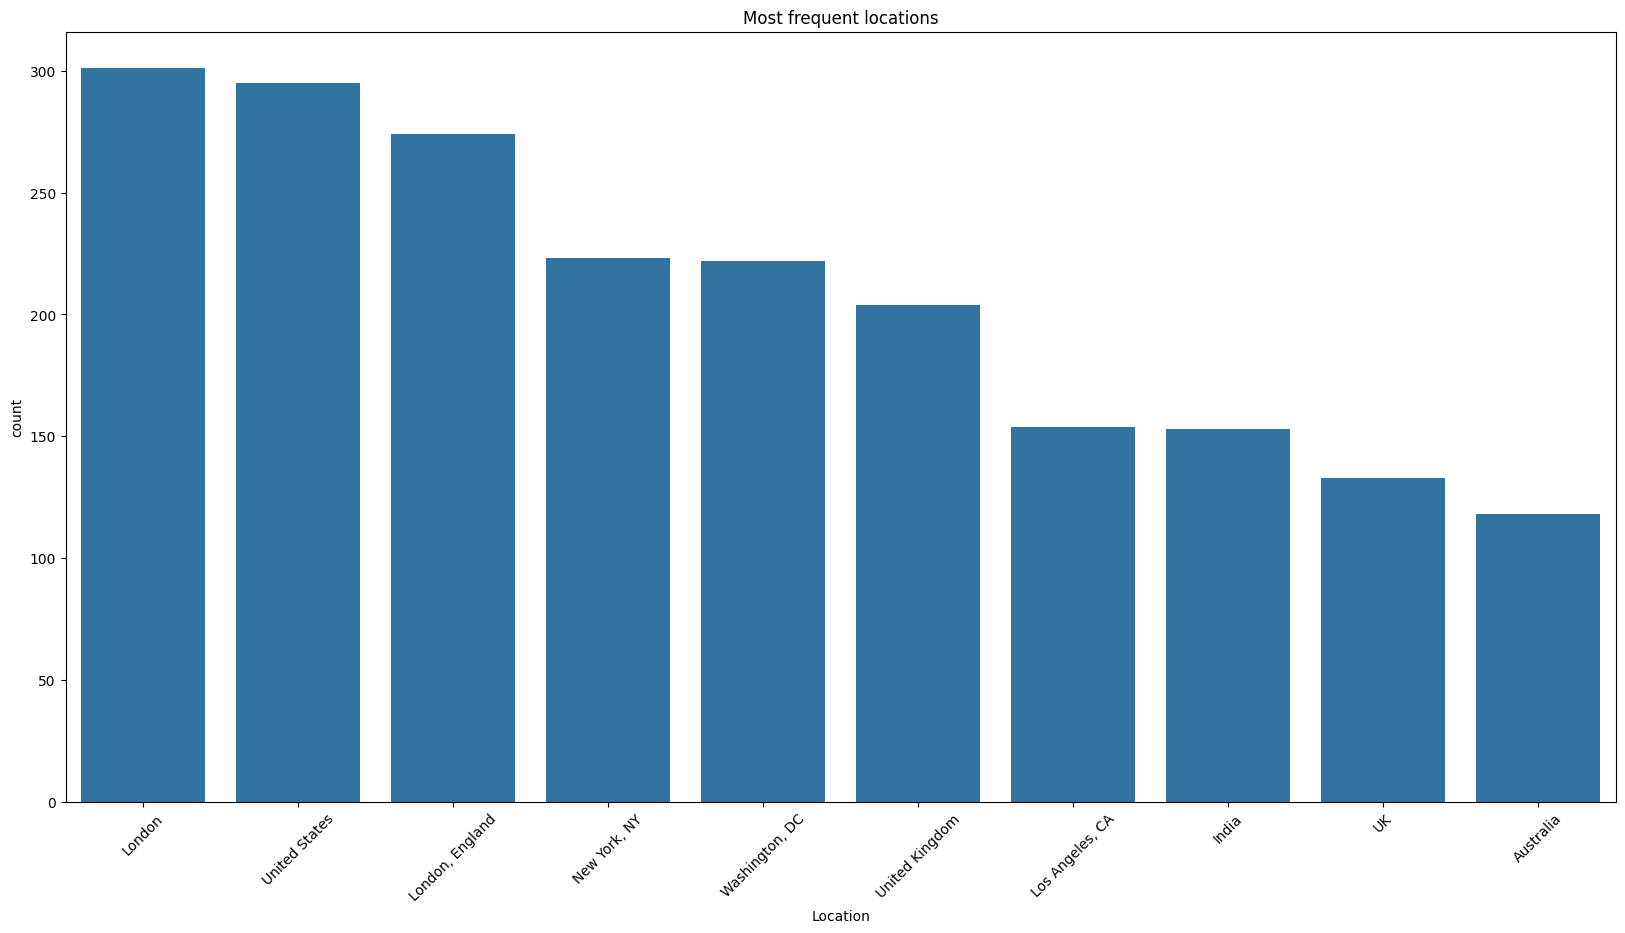

In [54]:
top_location = location.value_counts().drop('Unknown')[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=top_location.index, y=top_location.values)
ax.set_title('Most frequent locations')
ax.set_ylabel('count')
plt.xticks(rotation=45)
plt.show()


Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [45]:
def wide(text):
    if len(text.split(', ')) > 1:
      return text.split(', ')[-1]
    else:
      return text

WiderLocation = location.apply(wide)
len(WiderLocation.unique())

4921

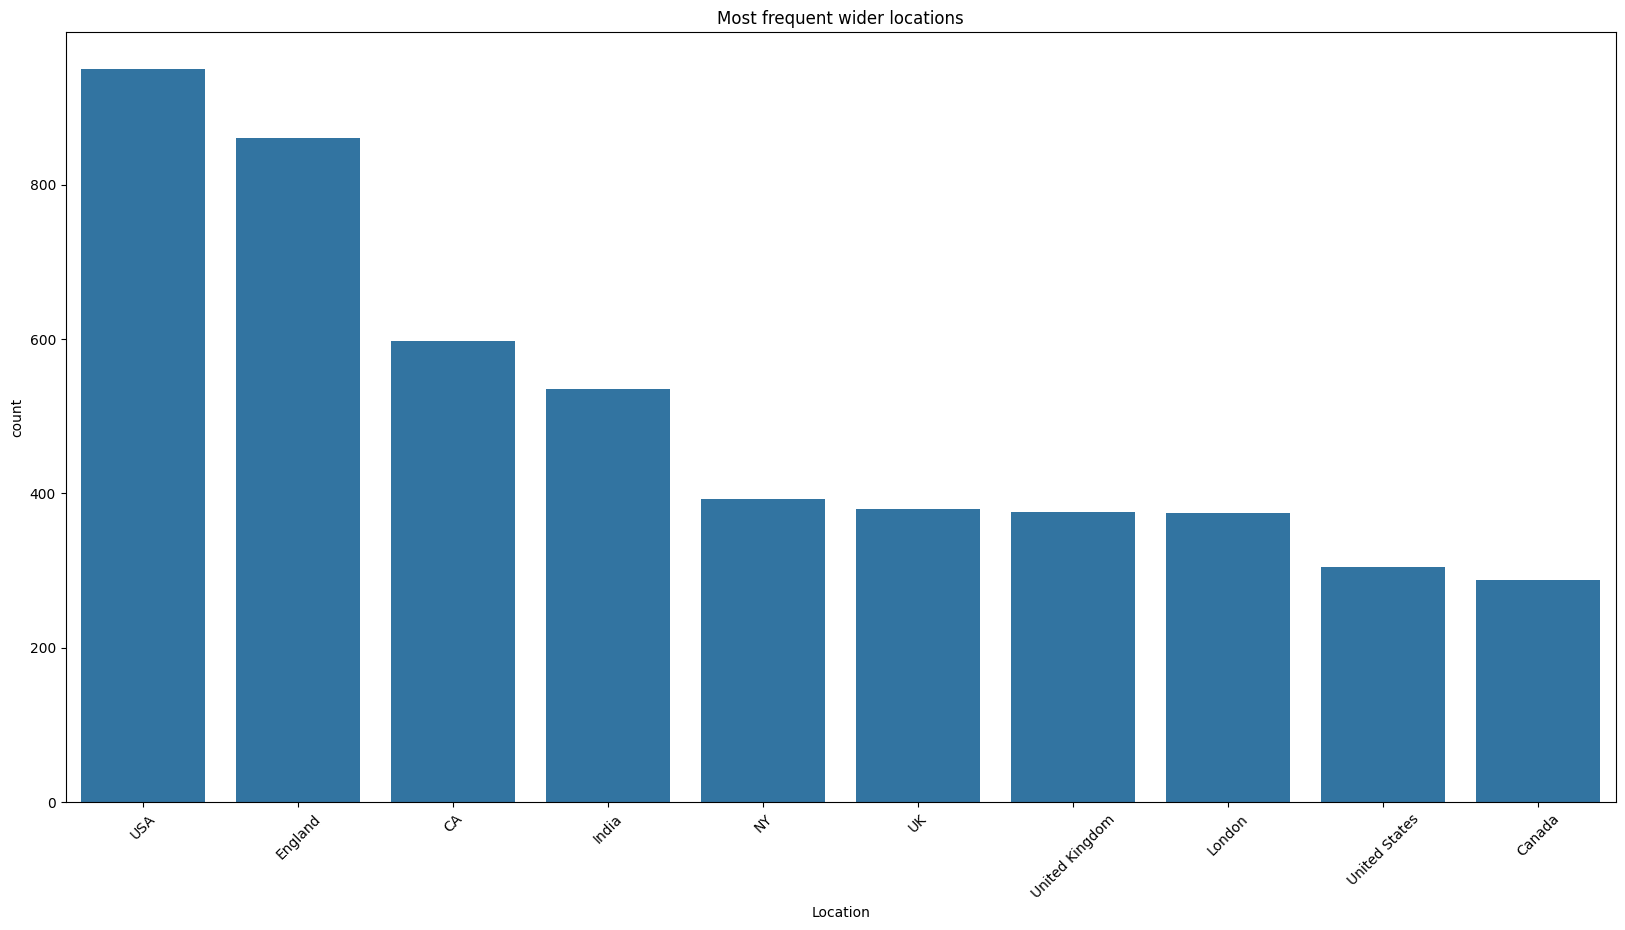

In [55]:
top_wider_location = WiderLocation.value_counts().drop('Unknown')[:10]

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.barplot(x=top_wider_location.index, y=top_wider_location.values)
ax.set_title('Most frequent wider locations')
ax.set_ylabel('count')
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [47]:
WiderLocation_count = WiderLocation.value_counts()
WiderLocation_count = WiderLocation_count[WiderLocation_count.values > 1]
len(WiderLocation_count)

1010

In [49]:
from sklearn.preprocessing import OneHotEncoder

cats = WiderLocation_count.index.values
encoder = OneHotEncoder(categories=[cats], sparse_output=False, handle_unknown='ignore').set_output()

In [50]:
WiderLocation_train = train['Location'].apply(wide)
WiderLocation_test = test['Location'].apply(wide)
WiderLocation_train_encoded = encoder.fit_transform(WiderLocation_train.values.reshape(-1, 1))
WiderLocation_test_encoded = encoder.transform(WiderLocation_test.values.reshape(-1, 1))

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [51]:
X_train_loc = np.hstack([WiderLocation_train_encoded, X_train_cv_df.toarray()])
X_test_loc = np.hstack([WiderLocation_test_encoded, X_test_cv_df.toarray()])

lr_loc = LogisticRegression(max_iter=500, random_state=42)
lr_loc.fit(X_train_loc, y_train)
y_train_pred_loc = lr_loc.predict(X_train_loc)
y_test_pred_loc = lr_loc.predict(X_test_loc)

print('TRAIN CV DF SCALED', accuracy_score(y_train, y_train_pred_cv_df_scaled))
print('TEST CV DF SCALED', accuracy_score(y_test, y_test_pred_cv_df_scaled))
print()
print('TRAIN CV LOC', accuracy_score(y_train, y_train_pred_loc))
print('TEST CV LOC', accuracy_score(y_test, y_test_pred_loc))

TRAIN CV DF SCALED 0.9416915847928236
TEST CV DF SCALED 0.8446282639027307

TRAIN CV LOC 0.9453225117471166
TEST CV LOC 0.8448275862068966


**Ответ:** Точность на тесте немного повысилась. Признак полезный, но не очень.

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)